Found 12000 validated image filenames belonging to 120 classes.
Found 8580 validated image filenames belonging to 120 classes.


c:\Users\Kraich\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1694 - loss: 3.7576
Epoch 1: val_loss improved from inf to 1.12860, saving model to best_model_mobilenet.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 523s 1s/step - accuracy: 0.1698 - loss: 3.7552 - val_accuracy: 0.7055 - val_loss: 1.1286 - learning_rate: 0.0010
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5278 - loss: 1.6422
Epoch 2: val_loss improved from 1.12860 to 0.89779, saving model to best_model_mobilenet.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 532s 1s/step - accuracy: 0.5279 - loss: 1.6420 - val_accuracy: 0.7402 - val_loss: 0.8978 - learning_rate: 0.0010
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6010 - loss: 1.3655
Epoch 3: val_loss improved from 0.89779 to 0.81363, saving model to best_model_mobilenet.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 541s 1s/step - accuracy: 0.6010 - loss: 1.3655 - val_accuracy: 0.7569 - val_loss: 0.8136 - learning_rate: 0.0010
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━

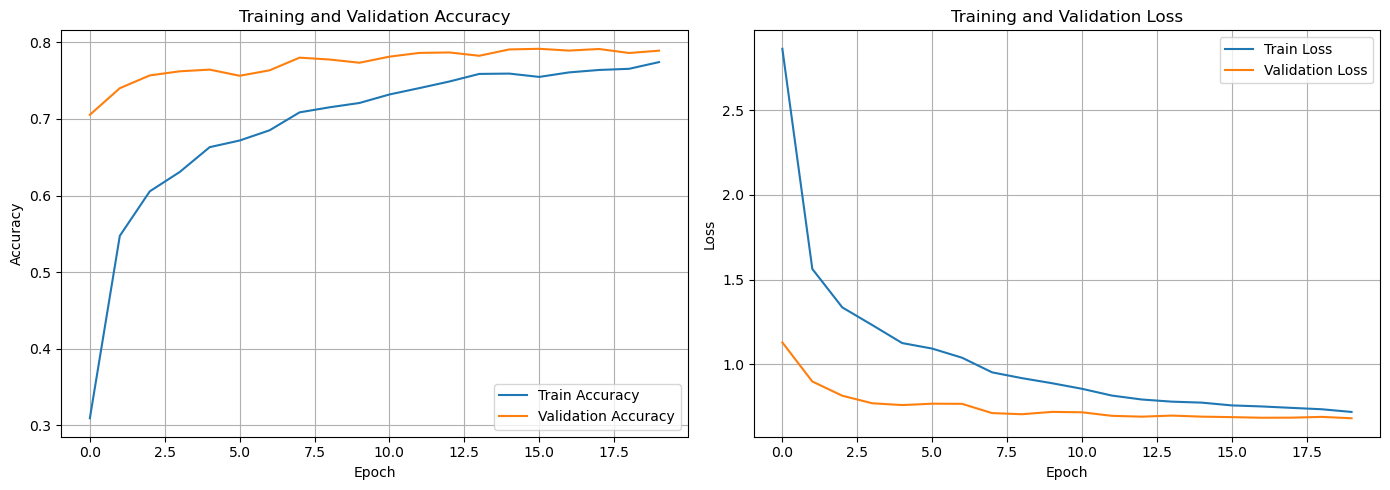


📋 Résumé des performances :
    Epoch  Train Accuracy  Validation Accuracy  Train Loss  Validation Loss
0       1        0.309417             0.705478    2.863806         1.128599
1       2        0.547500             0.740210    1.562942         0.897790
2       3        0.605583             0.756876    1.335742         0.813633
3       4        0.630833             0.762238    1.231341         0.769150
4       5        0.663250             0.764452    1.124812         0.758408
5       6        0.671917             0.756410    1.092341         0.766569
6       7        0.685250             0.763520    1.038172         0.765752
7       8        0.708667             0.780070    0.951846         0.711019
8       9        0.715250             0.777622    0.917433         0.704367
9      10        0.720917             0.773427    0.887618         0.718157
10     11        0.732000             0.781352    0.854663         0.715822
11     12        0.740333             0.786247    0.814575 

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (ModelCheckpoint, EarlyStopping, 
                                         ReduceLROnPlateau)

# --- Chargement des fichiers ---
def load_file_list(mat_path):
    mat = loadmat(mat_path)
    return [item[0][0] for item in mat["file_list"]]

# Chemins
raw_data_dir = "../data/raw/"
processed_images_dir = "../data/processed/Images"

train_list = load_file_list(os.path.join(raw_data_dir, "train_list.mat"))
test_list = load_file_list(os.path.join(raw_data_dir, "test_list.mat"))

# Labels
def get_label(path): return path.split('/')[0]

train_labels = [get_label(p) for p in train_list]
test_labels = [get_label(p) for p in test_list]

train_df = pd.DataFrame({
    'filename': [os.path.join(processed_images_dir, p) for p in train_list],
    'class': train_labels
})

test_df = pd.DataFrame({
    'filename': [os.path.join(processed_images_dir, p) for p in test_list],
    'class': test_labels
})

# --- Data Generators ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_generator.class_indices)

# --- Modèle MobileNetV2 ---
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # On freeze le backbone

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

# Compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- Callbacks ---
checkpoint = ModelCheckpoint(
    'best_model_mobilenet.keras', monitor='val_loss', save_best_only=True, verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, verbose=1
)

# --- Entraînement ---
import time
start_time = time.time()

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    verbose=1
)

training_time = time.time() - start_time

# --- Évaluation ---
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"✅ Test accuracy: {test_acc:.4f}")
print(f"⏰ Training time: {training_time:.2f} seconds")

# --- Graphiques ---
plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# --- Tableau Résumé ---
summary_table = pd.DataFrame({
    'Epoch': list(range(1, len(history.history['accuracy'])+1)),
    'Train Accuracy': history.history['accuracy'],
    'Validation Accuracy': history.history['val_accuracy'],
    'Train Loss': history.history['loss'],
    'Validation Loss': history.history['val_loss']
})

print("\n📋 Résumé des performances :")
print(summary_table)

# --- Conclusion ---
print("\n✍️ Conclusions :")
print(f"- Test Accuracy finale : {test_acc:.2%} - Test Loss : {test_loss:.4f}")
print(f"- Temps total d'entraînement : {training_time/60:.2f} minutes")
print("- Le modèle converge rapidement grâce au transfert d'apprentissage.")
print("- MobileNetV2 permet d'avoir une bonne généralisation même avec peu d'époques.")
print("- Entraînement optimisé sans surcoût de calcul.")
